<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/5_Dinamic_model_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# Feature engineering and scaling

In [4]:
data = mf.feature_engineering(data)
data = mf.feature_scaling(data)
data = pd.get_dummies(data)

# Dinamic model

In [5]:
init_splits = 4 # numero di split su cui il modello iniziale (t=0) si allena 
incoming_splits = 2 # nuovi split che arrivano ad ogni nuovo dt, e su cui si allena il nuovo modello
tot_splits = 10 # split totali in cui sarà diviso il dataset

In [6]:
def get_split_id(data, init_splits, incoming_splits, tot_splits): # serve per splittare il dataset in tot_splits
  '''
  in
  data: dataset che si vuole splittare
  init_splits: numero di split su cui il modello iniziale (t=0) si allena 
  incoming_splits: nuovi split che arrivano ad ogni nuovo dt, e su cui si allena il nuovo modello
  tot_splits: split totali in cui sarà diviso il dataset
  out
  id: dizionario che contiene (split : id righe selezionate)
  id_fraud: come id, solo che sono selezionate solo le transazioni fraudolente 
  '''
  id = {} # dizionario con (split : id_righe)
  id_fraud = {} # dizionario con (split: id righe transazioni fraudolente)
  for i in range(tot_splits):
    id[i] = data[(data['TransactionDT']>=(i/tot_splits)) & (data['TransactionDT']<((i + 1)/tot_splits))].index.tolist()
    id_fraud[i] = data[(data['TransactionDT']>=(i/tot_splits)) & (data['TransactionDT']<((i + 1)/tot_splits)) & (data['isFraud'] == 1)].index.tolist()
    
  return id, id_fraud

In [7]:
class model:
  name = 'XGBoost'

  def __init__(self, t): # costruttore
    '''
    in
    t: istante temporale
    '''
    self.t = t
    self.f1 = 0
    self.precision = 0
    self.recall = 0
    self.roc = 0
    self.proba = []
    self.prediction = []
    self.train_id = [] # lista con le righe su cui il modello si è allenato
    self.val_id = [] # lista con le righe su cui il modello viene validato
    return

  def __str__(self): # print dell'oggetto
    return f"{self.name}, at time {self.t}, with f1 score of {self.f1}"

  def init_xgb(self, estimators = 10, depth = 2): # inizializza xgb
    import xgboost 
    from xgboost import XGBClassifier
    self.xgb = XGBClassifier(n_estimators = estimators, max_depth = depth, 
                      objective='binary:logistic', learning_rate = 0.5, 
                      tree_method='gpu_hist')
    return f'{self.name} at time {self.t}, has been initialised.'
  
  def train_xgb(self, X_train, y_train): # traina il modello
    # self.xgb.fit(X_train.to_numpy(), y_train.to_numpy())
    self.xgb.fit(X_train.to_numpy(), y_train)
    return f'{self.name} is now trained!'

  def get_set(self, data, id_list): # restituisce il subset dati gli id delle righe
    # id_list: è l'elemento id[t] 
    subset = data.iloc[id_list,:]
    return subset

  def proba_predictions(self, X_val): # restituisce le probabilità
    if not self.xgb:
      return f'{self.name} is not declared. You need to use init_xgb'
    self.proba = self.xgb.predict_proba(X_val, validate_features = False)
    return self.proba

  def aggregate(self, soglia = 0.05): # resituisce la classe
    # if not self.proba:
    #   return f'self.proba is empty. Before aggregate, you need to use proba_predictions'
    self.prediction = []
    for proba in self.proba[:,1]:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

  def performance(self, y_val, soglia = 0.05): # printa le performance del modello 
    from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
    
    print('\n')
    print('Confusion matrix of model ', self.name,' of time ', self.t)
    mf.plot_cm(y_val, self.prediction, 'Blues', p = soglia, dynamic = True)
    
    self.score = f1_score(y_val, self.prediction).round(2)
    self.roc = roc_auc_score(y_val, self.prediction).round(2)
    self.precision = precision_score(y_val, self.prediction,  average='binary').round(2)
    self.recall = recall_score(y_val, self.prediction, average='binary').round(2)

    print('\n')
    print('Model f1 score: ', self.score)
    print('Model roc auc score: ', self.roc)
    print('Model recall: ', self.recall)
    print('Model precision: ', self.precision)
    print('\n')
    return 

In [8]:
class ensemble(model): # child class di model
  name = 'Ensemble'
  # come model_dict passare il dizionario in cui si salvano gli ensemble

  #override 
  def proba_predictions(self, model_dict, X_val): # restituisce le probabilità predette 
    prob = []
    for t in model_dict:
      prob.append(model_dict[t].proba_predictions(X_val)[:,1])
    self.proba = np.mean(prob, axis = 0)
    return f'Proba acquired.'
  
  #override
  def aggregate(self, soglia = 0.05): # restituisce la classe predetta 
    for proba in self.proba:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

In [9]:
def get_t_id(data, id, id_fraud, t, init_splits, incoming_splits): # restituisce la lista degli id corrispondente all'istante temporale t 
  '''
  data: dataset da cui selezionare le transazioni
  id: lista con gli id delle righe
  t: istante temporale
  init_splits: split totali in cui sarà diviso il dataset
  incoming_splits: nuovi split che arrivano ad ogni nuovo dt, e su cui si allena il nuovo modello
  out
  id_list: lista con gli id delle righe selezionate a seconda dell'istante temporale specificato  
  '''
  id_list = [] # lista che conterrà le righe da usare al tempo t
  id_list_fraud = [] # lista che conterrà le righe con transazioni fraud da usare al tempo t

  if t == 0: 
    start = 0
    end = init_splits
  else:
    start = incoming_splits * (t - 1) + init_splits
    end = start + incoming_splits

  if t == 1:
    start_fraud = 0
    end_fraud = init_splits
  else:
    start_fraud = 0
    end_fraud = incoming_splits * (t - 1) + init_splits + incoming_splits 

    

  for n in range(start,end):
    id_list += id[n]
  
  if t > 0:
    for n in range(start_fraud, end_fraud):
      id_list_fraud += id_fraud[n]

  return id_list, id_list_fraud

In [10]:
def train_model(sel_model, data, id_t, id_fraud_t): # funzione per sistemare il dataset e trainare il modello
  '''
  sel_model: modello da trainare
  data: dataset
  id_t: id delle righe su cui trainare il modello
  '''
  # Inizializzazione modello
  sel_model.init_xgb() # inizializzo xgb

  # Train test split
  subset = sel_model.get_set(data, id_t) # seleziono il subset su cui il modello si allenerà
  X_train, X_val, y_train, y_val = mf.split(subset, test_size = 0.2) # train test split
  # unione transazioni fraudolente degli step precedenti
  X_train_fraud = sel_model.get_set(data, id_fraud_t)
  X_train = pd.concat([X_train, X_train_fraud])
  y_train_fraud = np.ones((X_train_fraud.shape[0]))
  y_train = np.concatenate((y_train, y_train_fraud), axis=None)
  # salvataggio degli id nel modello
  sel_model.train_id = X_train.index.tolist() # salvo gli id del training set 
  sel_model.val_id = X_val.index.tolist() # salvo gli id del test set

  # Training del modello
  soglia = 0.05
  sel_model.train_xgb(X_train, y_train) # train di xgb 

  return f'Training ended. \n'

In [11]:
def test_model(sel_model, model_dict, t, data, soglia): # test del modello
  '''
  in
  sel_model: modello da trainare
  model_dict: dizionario contenente i vari modelli
  t: istante temporale
  data: dataset
  soglia: soglia sulla probabilità 
  '''
  id_list = []
  for i in model_dict:
    id_list += model_dict[i].val_id
  # id_list = last_model.val_id # seleziono le righe su cui va validato l'ultimo modello
  subset = sel_model.get_set(data, id_list) # seleziono il set su cui valido i dati
  y_val = subset['isFraud']
  X_val = subset.drop(columns=['isFraud'], axis = 1)

  sel_model.proba_predictions(X_val) # predict_proba
  sel_model.aggregate(soglia = soglia) # predict

  sel_model.performance(y_val, soglia = soglia) # valuta le performance del modello
  return 

In [12]:
def test_ensemble(ens, model_dict, t, data, id_t): # testa le performance dell'ensemble
  '''
  ens: ensemble da testare 
  model_dict: dizionario con i modelli
  t: istante temporale
  data: dataset
  id_t: righe da usare all'istante t-esimo
  '''
  id_list = []
  for i in model_dict:
    id_list += model_dict[i].val_id
  subset = model_dict[t].get_set(data, id_list) # seleziono il set su cui valido i dati
  # subset = model_dict[t].get_set(data, id_t) # seleziono il set su cui valido i dati
  y_val = subset['isFraud']
  X_val = subset.drop(columns=['isFraud'], axis = 1)
  ens.proba_predictions(model_dict, X_val) # predict_proba dell'ensemble
  ens.aggregate() # predict dell'ensemble
  ens.performance(y_val) # valuto le performance
  return f'Ensemble testing ended. \n'

In [13]:
def dinamic_model(data, id, id_fraud, init_splits, incoming_splits, tot_splits):
  tmax = np.ceil((tot_splits - init_splits) / incoming_splits)
  model_dict = {}
  ensemble_dict = {}
  soglia = 0.05

  for t in range(int(tmax + 1)):
    print('Time ', t)
    id_t, id_fraud_t = get_t_id(data, id, id_fraud, t, init_splits, incoming_splits) # ottengo gli id delle righe da usare al tempo t-esimo
    model_dict[t] = model(t) # inizializzo il modello t-esimo 
    train_model(model_dict[t], data, id_t, id_fraud_t) # train e test del modello t-esimo
    if t > 0:
      ensemble_dict[t] = ensemble(t) # inizializzo l'ensemble t-esimo
      test_ensemble(ensemble_dict[t], model_dict, t, data, id_t) # testo l'ensemble
    for i in model_dict:
      test_model(model_dict[i], model_dict, t, data, soglia)

  return model_dict, ensemble_dict

Time  0


Confusion matrix of model  XGBoost  of time  0


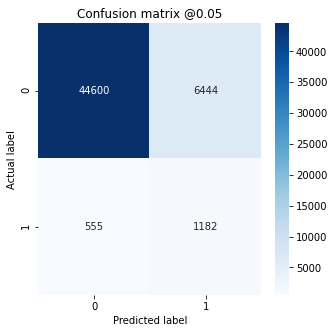



Model f1 score:  0.25
Model roc auc score:  0.78
Model recall:  0.68
Model precision:  0.15


Time  1


Confusion matrix of model  Ensemble  of time  1


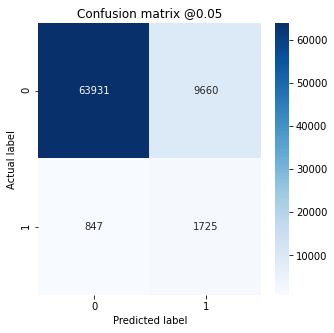



Model f1 score:  0.25
Model roc auc score:  0.77
Model recall:  0.67
Model precision:  0.15




Confusion matrix of model  XGBoost  of time  0


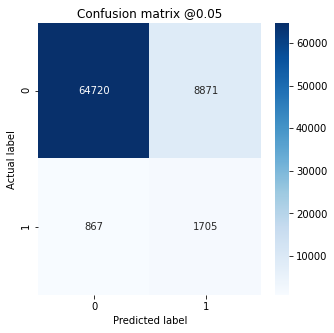



Model f1 score:  0.26
Model roc auc score:  0.77
Model recall:  0.66
Model precision:  0.16




Confusion matrix of model  XGBoost  of time  1


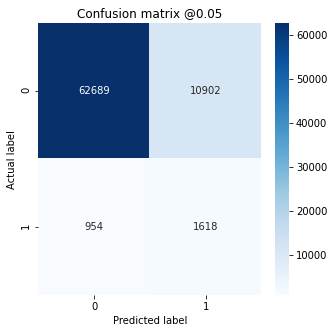



Model f1 score:  0.21
Model roc auc score:  0.74
Model recall:  0.63
Model precision:  0.13


Time  2


Confusion matrix of model  Ensemble  of time  2


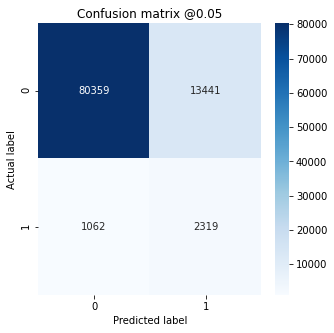



Model f1 score:  0.24
Model roc auc score:  0.77
Model recall:  0.69
Model precision:  0.15




Confusion matrix of model  XGBoost  of time  0


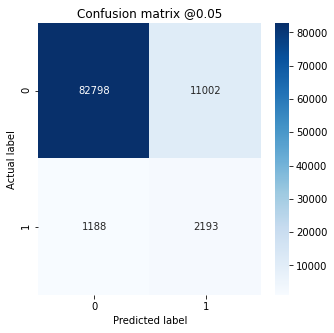



Model f1 score:  0.26
Model roc auc score:  0.77
Model recall:  0.65
Model precision:  0.17




Confusion matrix of model  XGBoost  of time  1


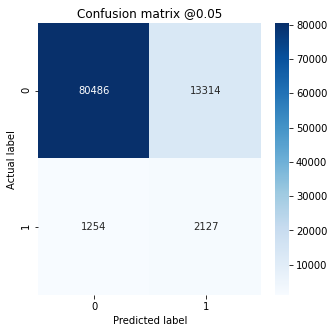



Model f1 score:  0.23
Model roc auc score:  0.74
Model recall:  0.63
Model precision:  0.14




Confusion matrix of model  XGBoost  of time  2


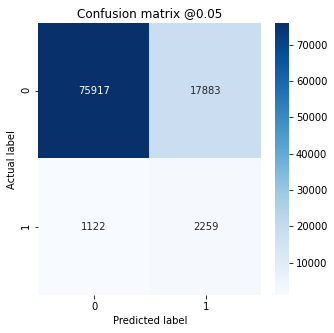



Model f1 score:  0.19
Model roc auc score:  0.74
Model recall:  0.67
Model precision:  0.11


Time  3


Confusion matrix of model  Ensemble  of time  3


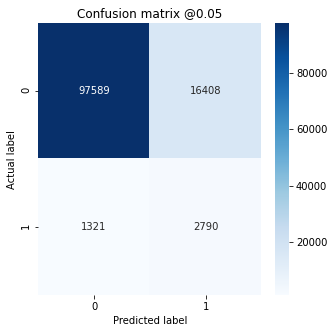



Model f1 score:  0.24
Model roc auc score:  0.77
Model recall:  0.68
Model precision:  0.15




Confusion matrix of model  XGBoost  of time  0


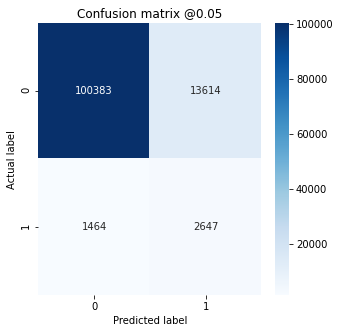



Model f1 score:  0.26
Model roc auc score:  0.76
Model recall:  0.64
Model precision:  0.16




Confusion matrix of model  XGBoost  of time  1


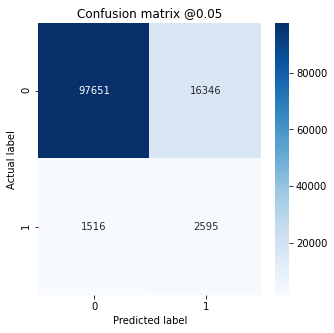



Model f1 score:  0.23
Model roc auc score:  0.74
Model recall:  0.63
Model precision:  0.14




Confusion matrix of model  XGBoost  of time  2


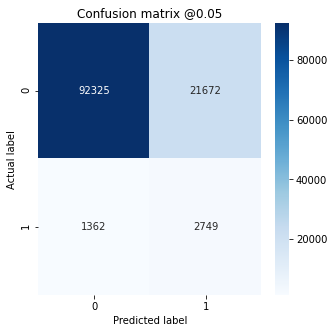



Model f1 score:  0.19
Model roc auc score:  0.74
Model recall:  0.67
Model precision:  0.11




Confusion matrix of model  XGBoost  of time  3


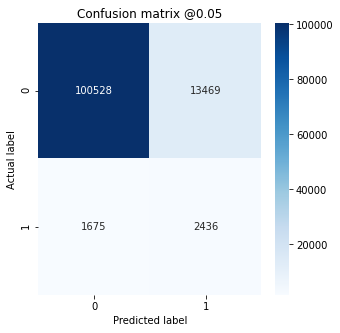



Model f1 score:  0.24
Model roc auc score:  0.74
Model recall:  0.59
Model precision:  0.15




In [14]:
id, id_fraud = get_split_id(data, init_splits, incoming_splits, tot_splits) # splitta le righe in base agli split dichiarati
model_dict, ensemble_dict = dinamic_model(data, id, id_fraud, init_splits, incoming_splits, tot_splits)